In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# data https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview

In [2]:
df = pd.read_csv('train.csv')

In [3]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# 1. Executive Summary/ Busienss Understanding

## Project Description from [Kaggle](www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview/evaluation)
### Goal
It is your job to predict the sales price for each house. For each Id in the test set, you must predict the value of the SalePrice variable. 

### Metric
Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

# 2. Data Understanding

## 2.1 Explore the numeric variables

Show some description information about the data

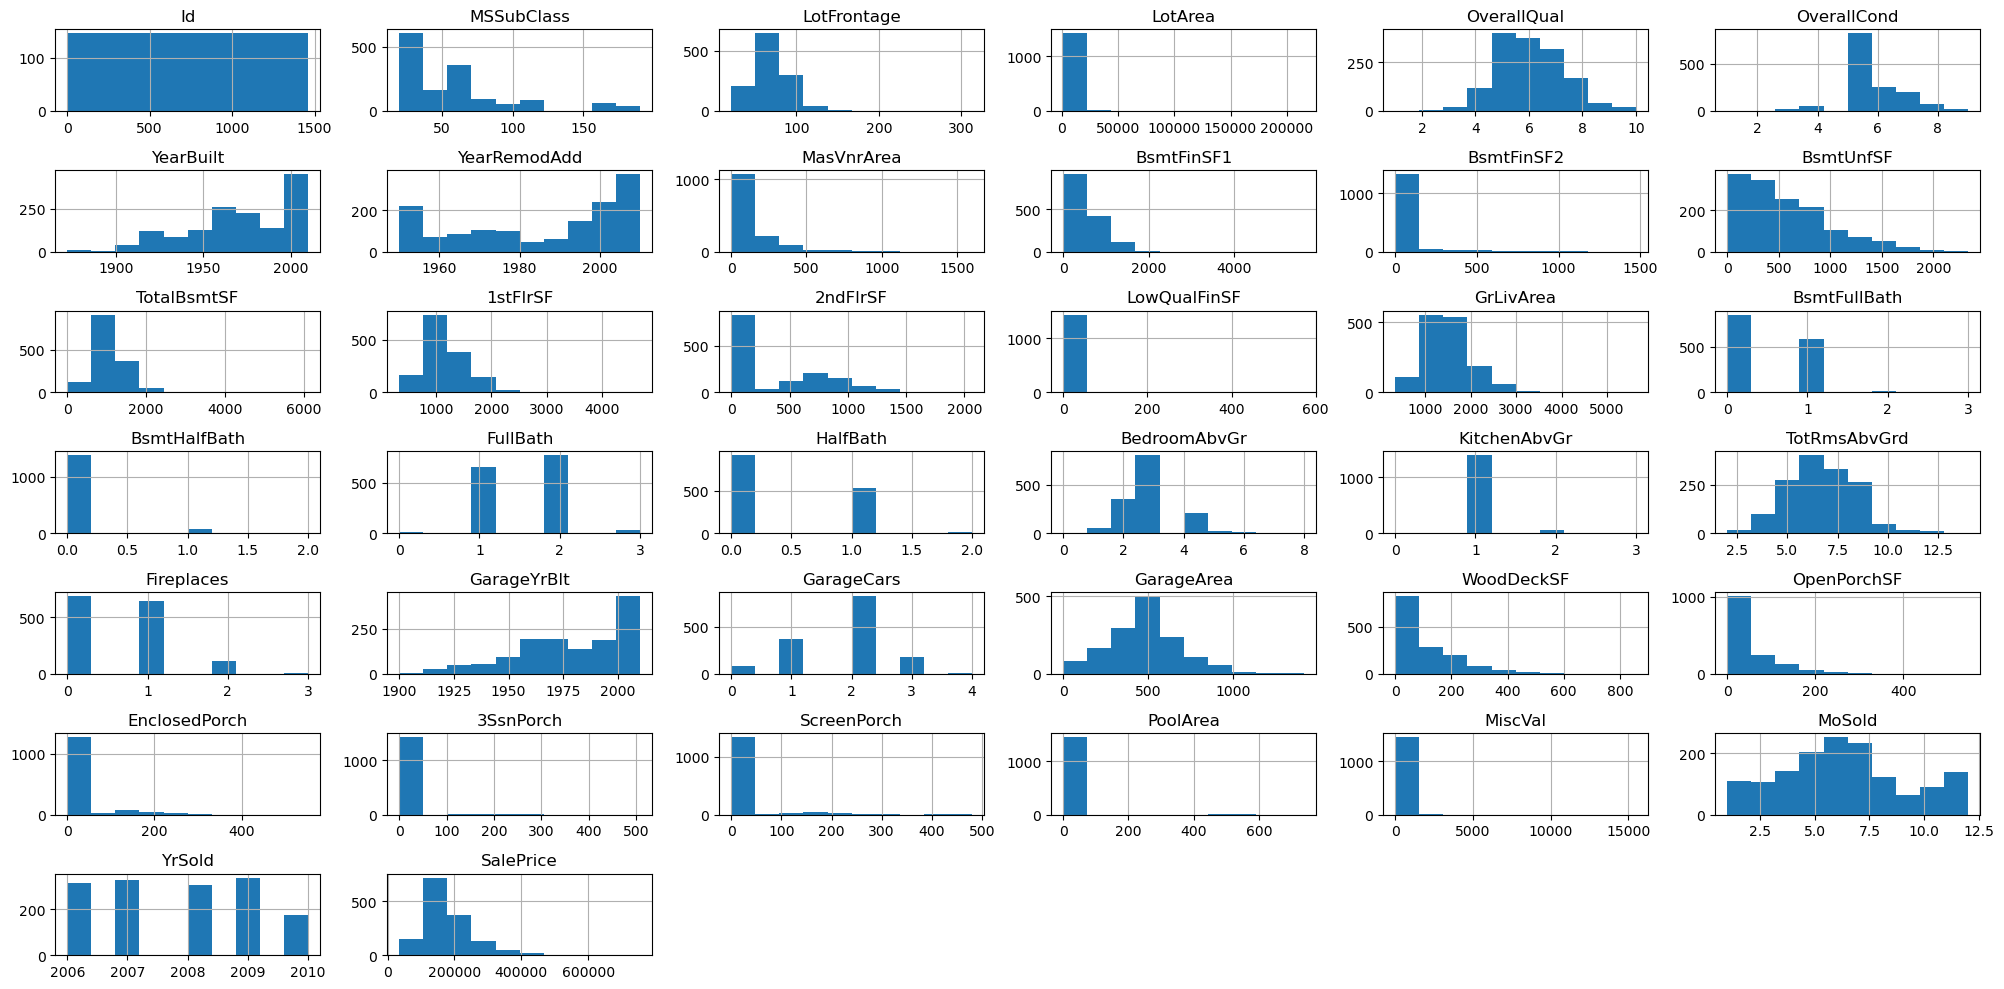

In [20]:
df.hist(figsize=(20, 10));
plt.tight_layout()

General Observations:
* Sales data roughly between 2006 and 2010.
* More houses sold in the summer months.
* Most houses between 1000 - 2000 square ft.
* Most houses built after 1950.

In [48]:
corr = df.corr(numeric_only=True)
corr.style.background_gradient(cmap='coolwarm', axis=None)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.011156,-0.010601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050298,-0.005024,-0.005968,-0.007940,-0.015415,0.010496,0.005590,-0.044230,0.008273,0.002289,-0.020155,0.005587,0.006784,0.037719,0.002951,0.027239,-0.019772,0.000072,0.016570,0.017634,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917
MSSubClass,0.011156,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,-0.065649,-0.140759,-0.238518,-0.251758,0.307886,0.046474,0.074853,0.003491,-0.002333,0.131608,0.177354,-0.023438,0.281721,0.040380,-0.045569,0.085072,-0.040110,-0.098672,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,-0.010601,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,0.049900,0.132644,0.392075,0.457181,0.080177,0.038469,0.402797,0.100949,-0.007234,0.198769,0.053532,0.263170,-0.006069,0.352096,0.266639,0.070250,0.285691,0.344997,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
LotArea,-0.033226,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,0.111170,-0.002618,0.260833,0.299475,0.050986,0.004779,0.263116,0.158155,0.048046,0.126031,0.014259,0.119690,-0.017784,0.190015,0.271364,-0.024947,0.154871,0.180403,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,-0.028365,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,-0.059119,0.308159,0.537808,0.476224,0.295493,-0.030429,0.593007,0.111098,-0.040150,0.550600,0.273458,0.101676,-0.183882,0.427452,0.396765,0.547766,0.600671,0.562022,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,0.012609,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,0.040229,-0.136841,-0.171098,-0.144203,0.028942,0.025494,-0.079686,-0.054942,0.117821,-0.194149,-0.060769,0.012980,-0.087001,-0.057583,-0.023820,-0.324297,-0.185758,-0.151521,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,-0.012713,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,-0.049107,0.149040,0.391452,0.281986,0.010308,-0.183784,0.199010,0.187599,-0.038162,0.468271,0.242656,-0.070651,-0.174800,0.095589,0.147716,0.825667,0.537850,0.478954,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,-0.021998,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,-0.067759,0.181133,0.291066,0.240379,0.140024,-0.062419,0.287389,0.119470,-0.012337,0.439046,0.183331,-0.040581,-0.149598,0.191740,0.112581,0.642277,0.420622,0.371600,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,-0.050298,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,-0.072319,0.114442,0.363936,0.344501,0.174561,-0.069071,0.390857,0.085310,0.026673,0.276833,0.201444,0.102821,-0.037610,0.280682,0.249070,0.252691,0.364204,0.373066,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493
BsmtFinSF1,-0.005024,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,-0.050117,-0.495251,0.522396,0.445863,-0.137079,-0.064503,0.208171,0.649212,0.067418,0.058543,0.004262,-0.107355,-0.081007,0.044316,0.260011,0.153484,0.224054,0.296970,0.204306,0.111761,-0.102303,0.026451

General Observations:
* Sales price looks to be correlated with
    * OverallQual: Rates the overall material and finish of the house
    * GrLivArea: Above grade (ground) living area square feet
    * Other features related to square feet like GarageCars, GarageArea, Total basement sq ft, etc...
    

    
The above correlations make a lot of sense.  It might be useful to create some latent features with PCA to see if these features can be reduced and grouped into categories (ex. a square foot feature, a quality feature, etc...)

## 2.2 Explore the categorical variables

In [52]:
non_numeric_cols = df.select_dtypes(exclude='number').columns

In [53]:
df_len =  df.shape[0]
for col in df[non_numeric_cols]:        
        # get info about top values
        names = list(df[col].value_counts().index)
        sliced_names = [str(name)[:25] for name in names]
        values = list(df[col].value_counts())
        print(f'{df[col].name}: {list(zip(sliced_names,values))}')

MSZoning: [('RL', 1151), ('RM', 218), ('FV', 65), ('RH', 16), ('C (all)', 10)]
Street: [('Pave', 1454), ('Grvl', 6)]
LotShape: [('Reg', 925), ('IR1', 484), ('IR2', 41), ('IR3', 10)]
LandContour: [('Lvl', 1311), ('Bnk', 63), ('HLS', 50), ('Low', 36)]
Utilities: [('AllPub', 1459), ('NoSeWa', 1)]
LotConfig: [('Inside', 1052), ('Corner', 263), ('CulDSac', 94), ('FR2', 47), ('FR3', 4)]
LandSlope: [('Gtl', 1382), ('Mod', 65), ('Sev', 13)]
Neighborhood: [('NAmes', 225), ('CollgCr', 150), ('OldTown', 113), ('Edwards', 100), ('Somerst', 86), ('Gilbert', 79), ('NridgHt', 77), ('Sawyer', 74), ('NWAmes', 73), ('SawyerW', 59), ('BrkSide', 58), ('Crawfor', 51), ('Mitchel', 49), ('NoRidge', 41), ('Timber', 38), ('IDOTRR', 37), ('ClearCr', 28), ('StoneBr', 25), ('SWISU', 25), ('MeadowV', 17), ('Blmngtn', 17), ('BrDale', 16), ('Veenker', 11), ('NPkVill', 9), ('Blueste', 2)]
Condition1: [('Norm', 1260), ('Feedr', 81), ('Artery', 48), ('RRAn', 26), ('PosN', 19), ('RRAe', 11), ('PosA', 8), ('RRNn', 5), ('

General Observations:
* It looks like some columns have high cardinality (Neighborhood, Exterior1st, Exterior2nd).  These may have to be dealt with later.
* Some features don't appear too informative (Street, Utilities)
* It looks like for many of the features the categories are very skewed to the top value (where the second highest value in a column is almost a factor of 10 lower than the top value)
* Some non-numeric featuers appear ordinal (like BsmtQual and BsmtCond), these could be re-encoded to numerical

Relationship with Target Variable

Nature of categorical data: If it's categorical, is it nominal (no natural order) or ordinal (has a natural order)?

C:\git_repos\housing\envs\Lib\site-packages\pandas\plotting\_matplotlib\core.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


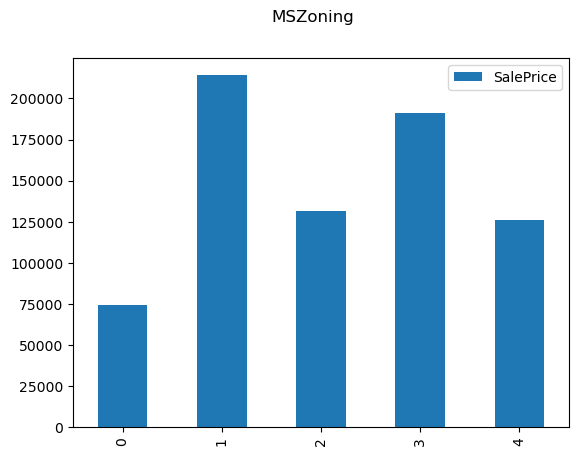

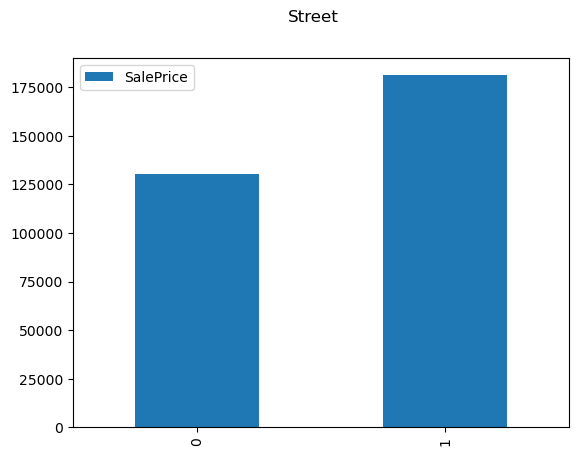

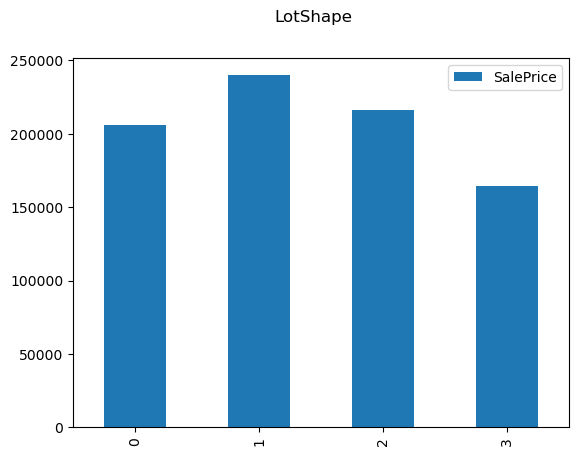

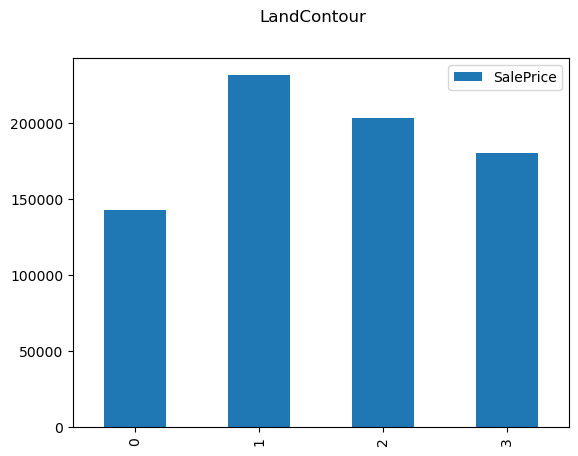

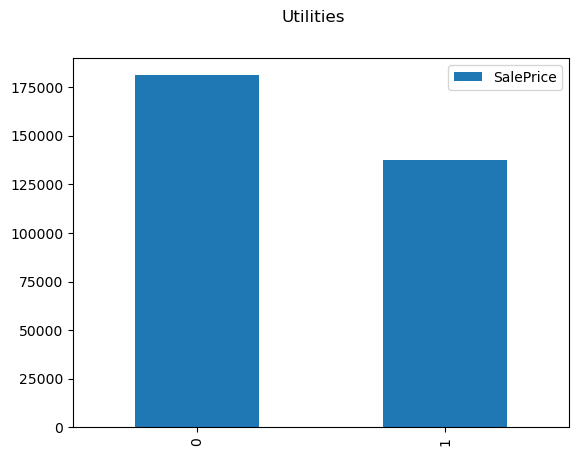

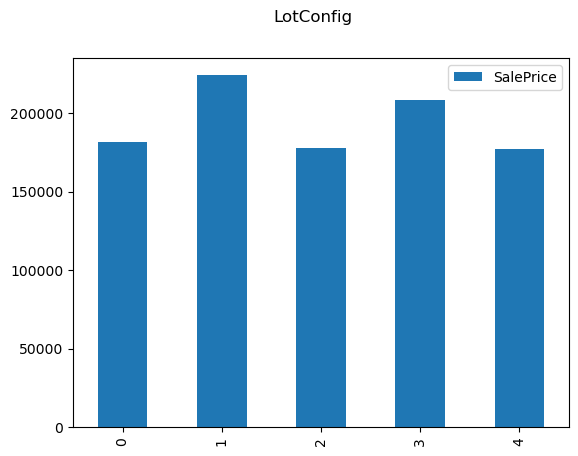

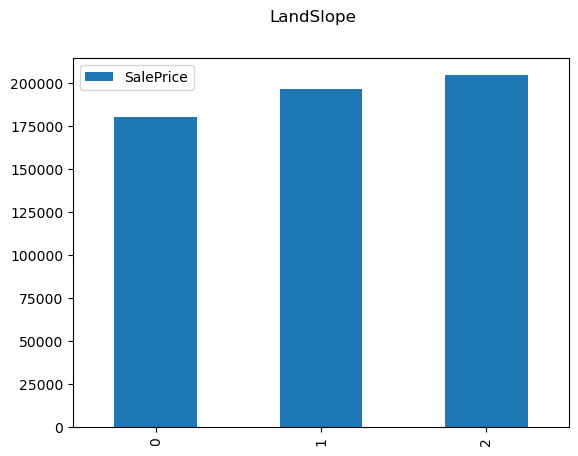

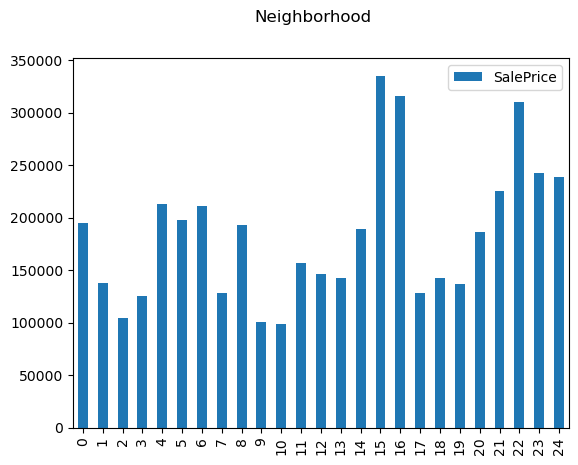

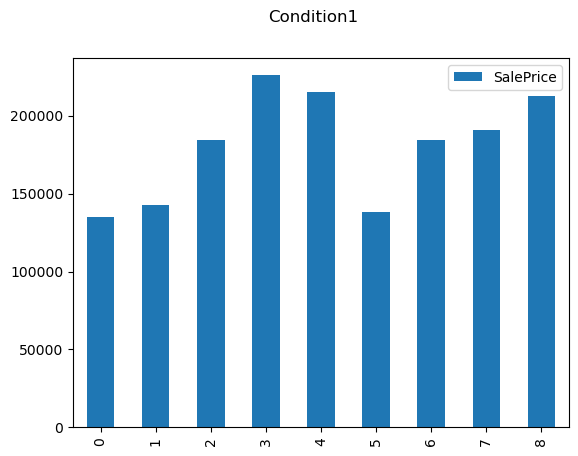

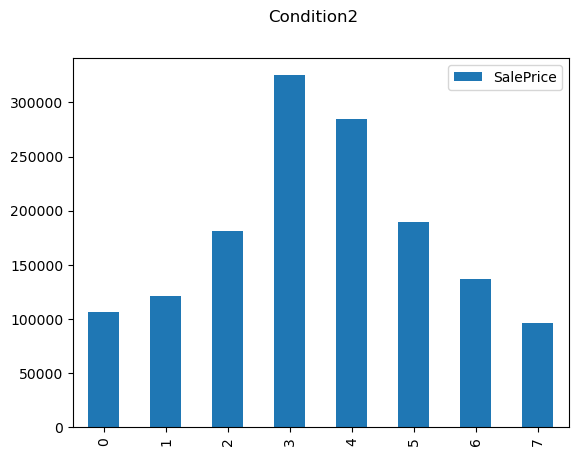

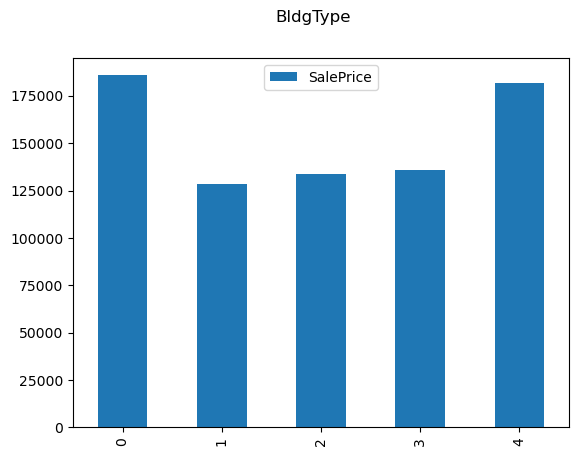

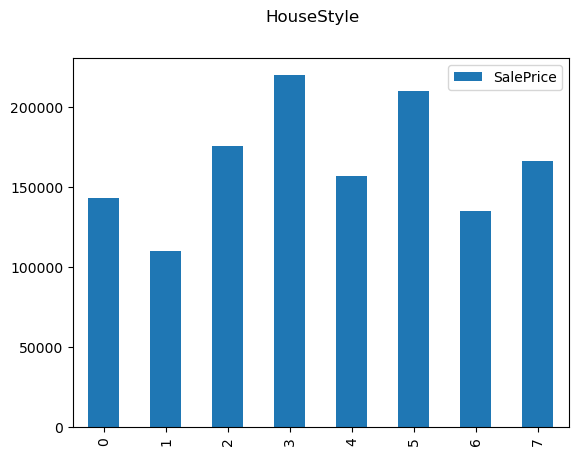

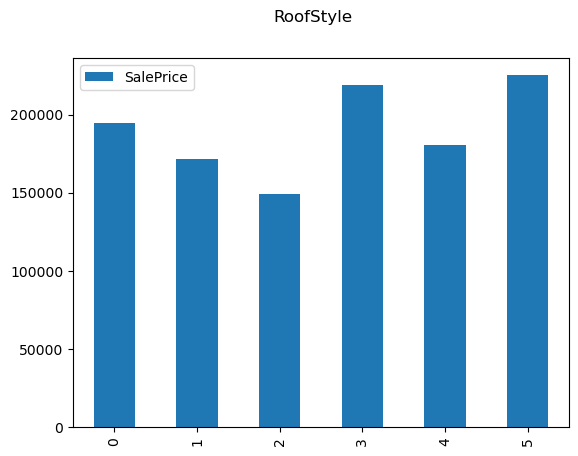

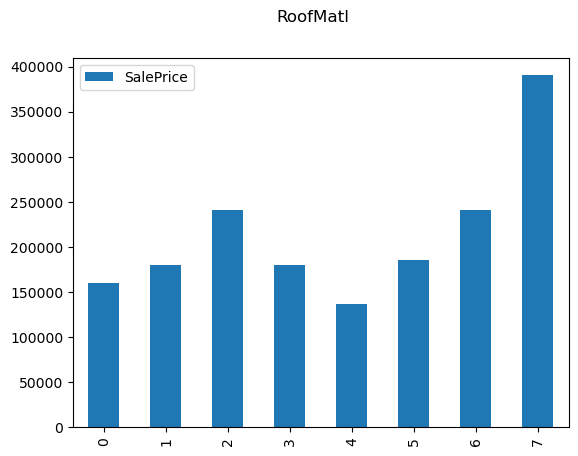

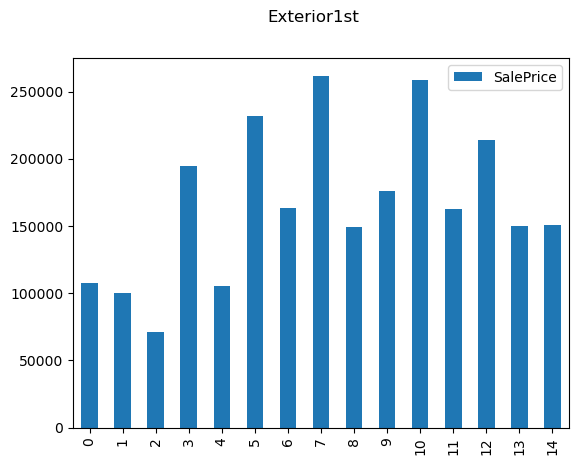

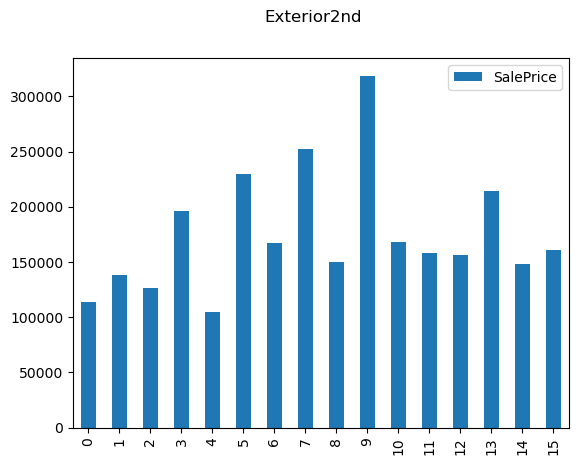

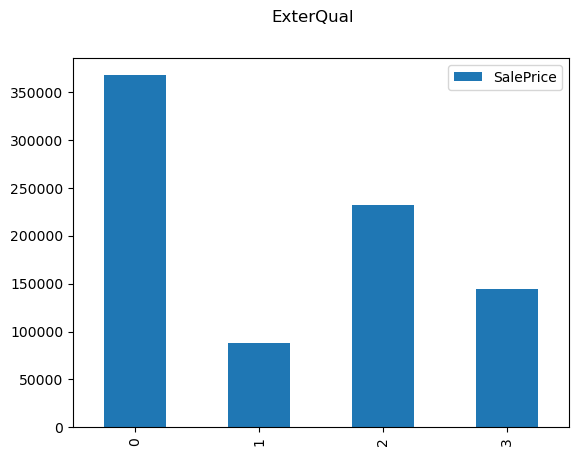

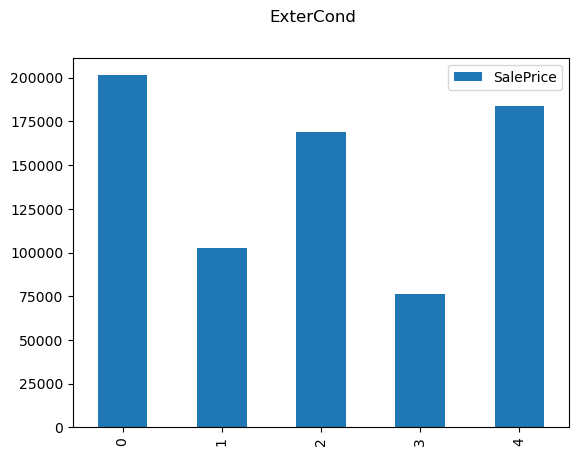

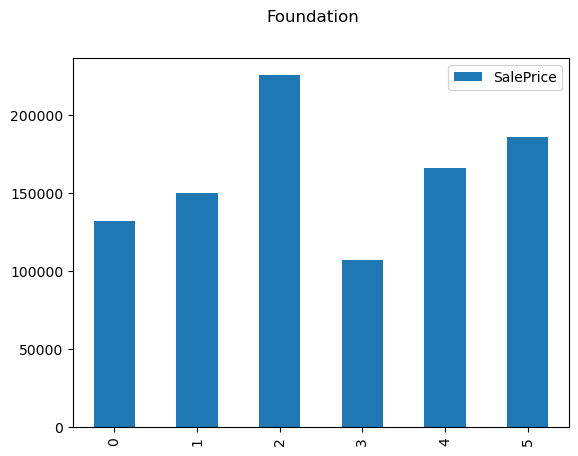

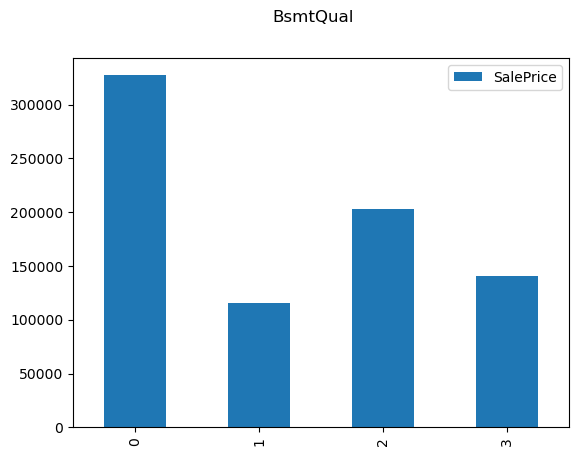

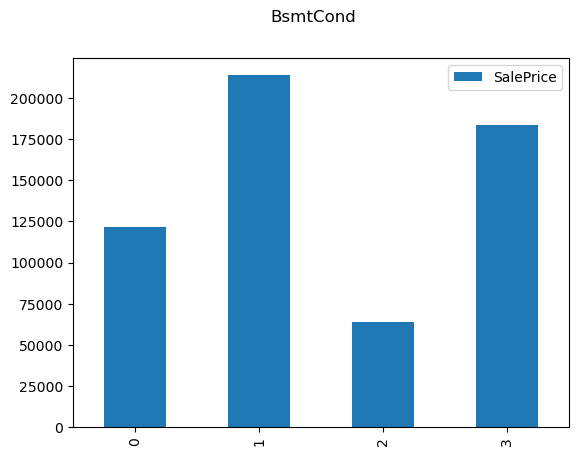

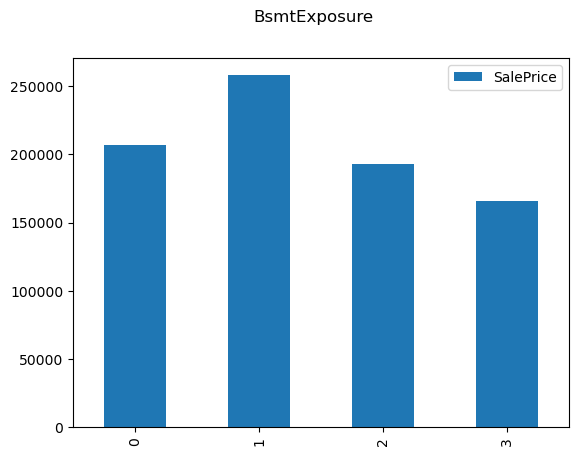

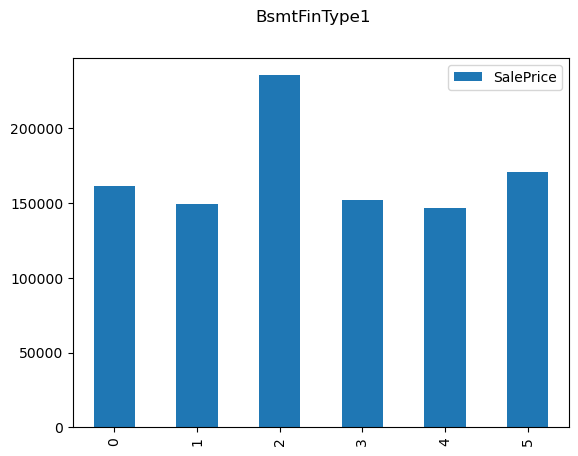

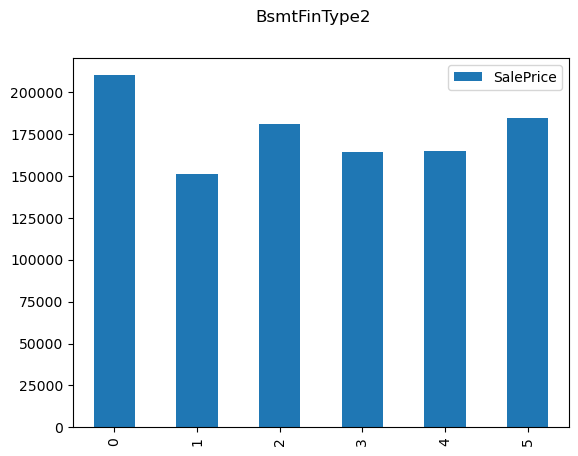

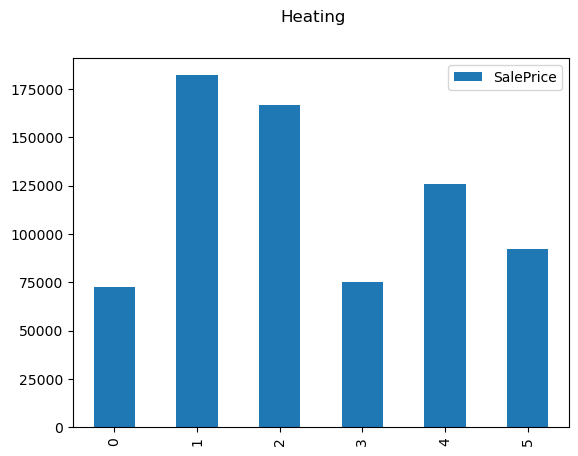

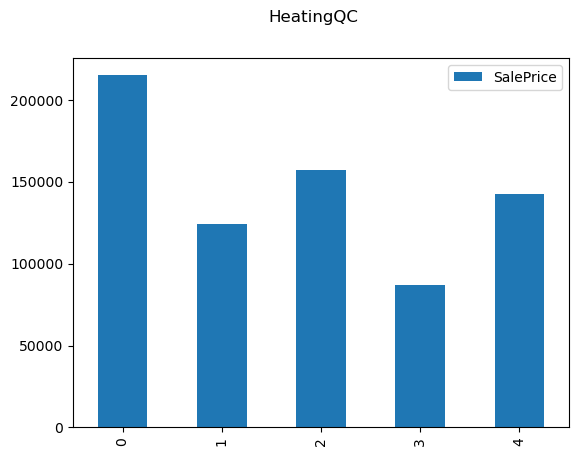

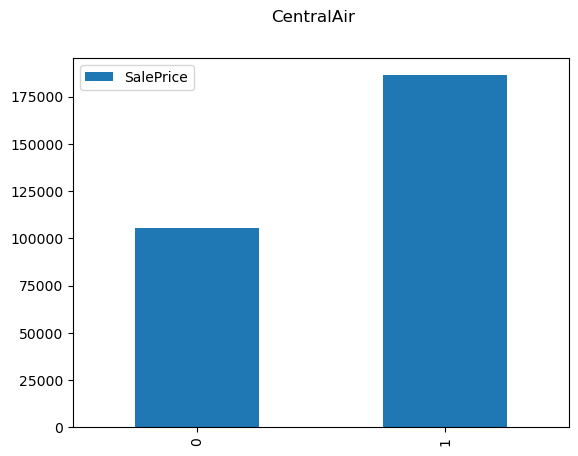

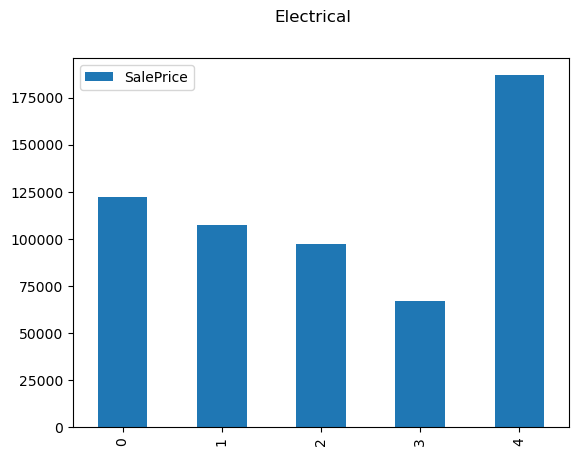

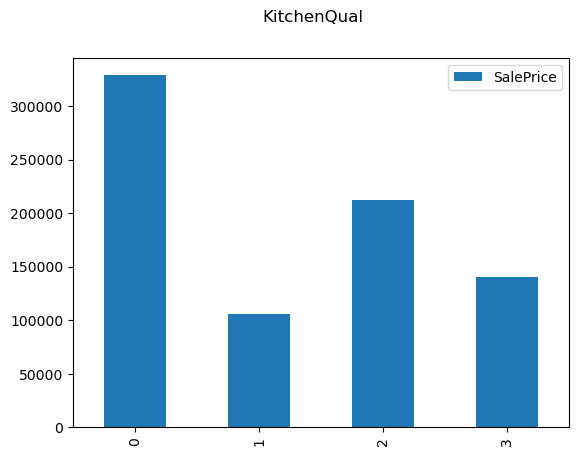

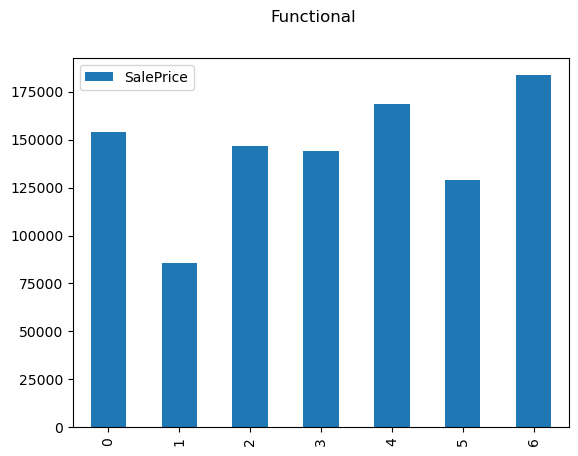

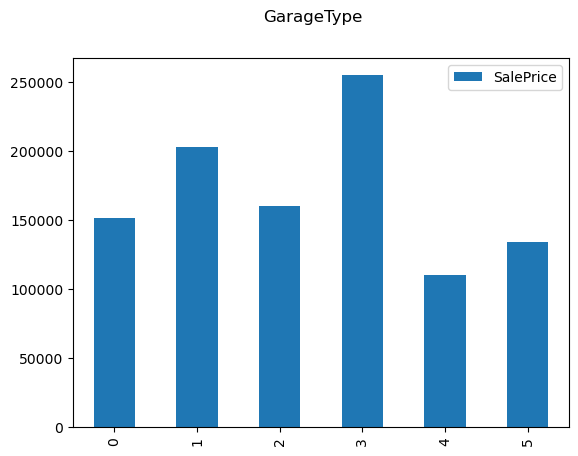

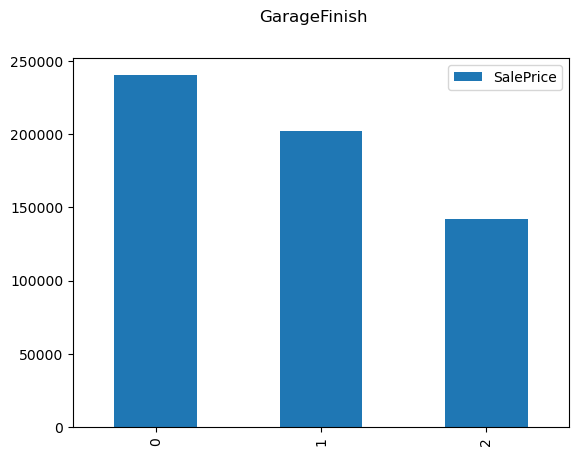

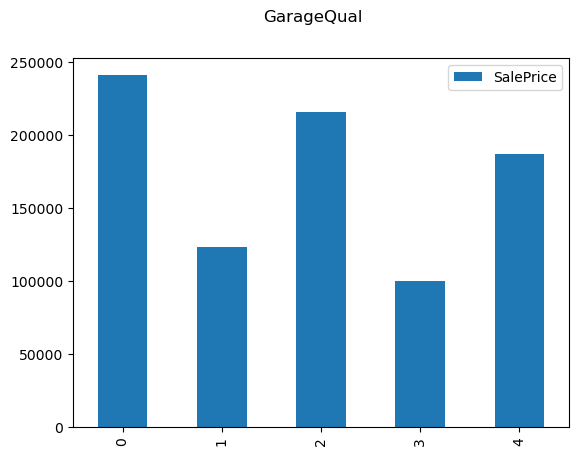

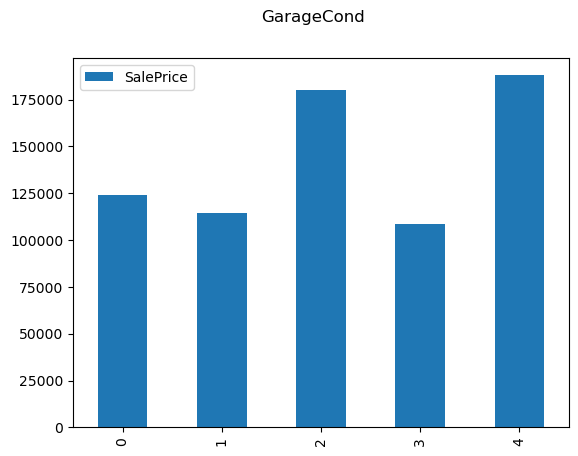

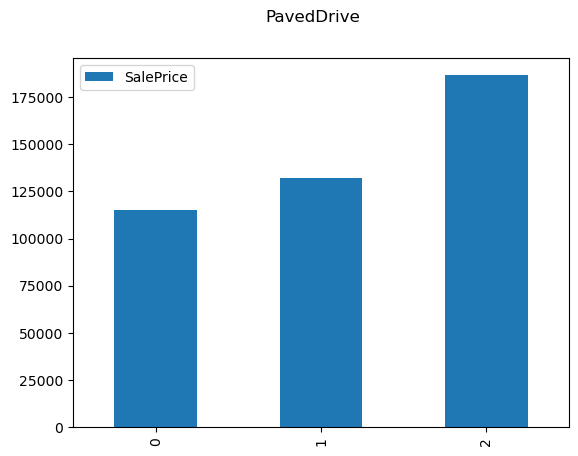

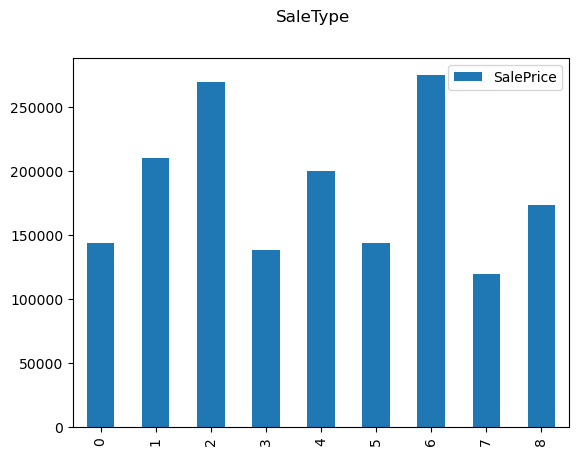

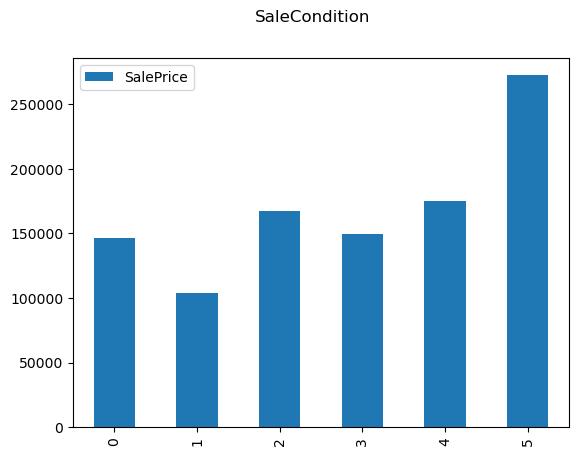

In [74]:
for col in df[non_numeric_cols]:
    df.groupby(col)['SalePrice'].mean().reset_index().plot.bar()
    plt.suptitle(col);

# 3. Data Preparation

## 3.1 identify missing cols

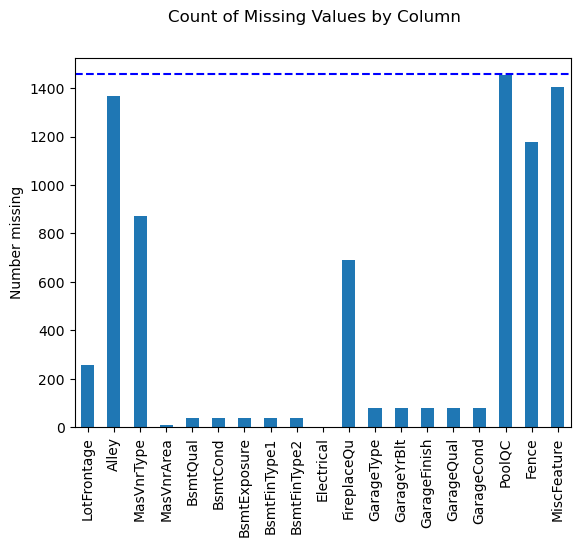

In [4]:
# identify and plot
missing_cols = df.columns[df.isna().any()].to_list()

fig, ax = plt.subplots()
df[missing_cols].isna().sum().plot.bar(ax=ax);
ax.set_ylabel('Number missing');
fig.suptitle('Count of Missing Values by Column');
plt.axhline(y = df.shape[0], color = 'b', linestyle = '--');

Drop columns missing more than 600 values

In [5]:
drop_cols = df.columns[df.isna().sum() > 600].to_list()
df.drop(columns=drop_cols, inplace = True)

## 3.2 Identify outlier rows

C:\git_repos\housing\envs\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\git_repos\housing\envs\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


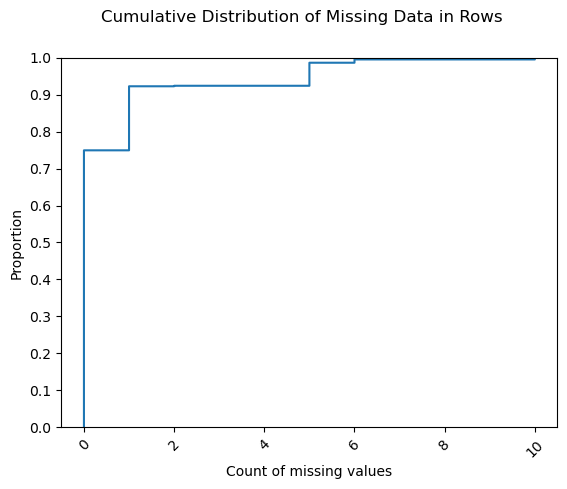

In [16]:
# identify and plot missing rows
missing_row = df.shape[1] - df.count(axis=1) # number of missing values per row

fig, ax = plt.subplots()
sns.ecdfplot(missing_row, ax=ax); 
plt.xticks(rotation=45);
ax.set_yticks(list(np.arange(0.0,1.1,0.1)));
plt.suptitle('Cumulative Distribution of Missing Data in Rows');
ax.set_xlabel('Count of missing values');

There are not many rows with lots of missing values.  Therefore these will be left as is and their values will be imputed.
The chart above shows that ~95% of rows are missings 5 or fewer values.

# 4. Modeling

# 5. Evaluation